In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pickle

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline, Pipeline

from catboost import CatBoostClassifier

import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline

#### Подключение библиотек и скриптов

#### Пути к директориям и файлам

In [2]:
TRAIN_DATASET_PATH = './CreditDefault.data/course_project_train.csv'
TEST_DATASET_PATH = './CreditDefault.data/course_project_test.csv'

#### Вспомогательные функции

In [3]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
        print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
        print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
        print('CONFUSION MATRIX\n')
        print(pd.crosstab(y_test_true, y_test_pred))
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [4]:
# просмотр значимых признаков для модели
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    if get_top is not None:
        feature_importances=feature_importances.sort_values('importance', ascending=False)[:get_top]
    else:          
        feature_importances = feature_importances.sort_values('importance', ascending=False)
    
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(x='importance', y='feature', data=feature_importances)
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

In [5]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold)), zero_division=1))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [6]:
def show_learning_curve_plot(estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    #Determines cross-validated training and test scores for different training set sizes.
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [7]:
# функция просмотра основной информации по датасету:
def show_me_info(df):
    data=df.copy()
    mask=data.isnull()
    missing=mask.sum()
    missing_percent=mask.mean()*100
    data_types=data.dtypes
    unique_values=data.nunique()
    data=pd.concat([data.count(), missing, missing_percent, data_types, unique_values],
                   axis=1,
                   keys=['Total count','Total missing', 'Percent missing', 'Types', 'Unique values']).sort_values(
        by='Total missing', ascending=False)
    return data

#### Загрузка данных

- **Home Ownership** - домовладение
- **Annual Income** - годовой доход
- **Years in current job** - количество лет на текущем месте работы
- **Tax Liens** - налоговые обременения
- **Number of Open Accounts** - количество открытых счетов
- **Years of Credit History** - количество лет кредитной истории
- **Maximum Open Credit** - наибольший открытый кредит
- **Number of Credit Problems** - количество проблем с кредитом
- **Months since last delinquent** - количество месяцев с последней просрочки платежа
- **Bankruptcies** - банкротства
- **Purpose** - цель кредита
- **Term** - срок кредита
- **Current Loan Amount** - текущая сумма кредита
- **Current Credit Balance** - текущий кредитный баланс
- **Monthly Debt** - ежемесячный долг
- **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

#### Загрузка подготовленных датасетов

In [8]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

#### Анализ данных

In [9]:
show_me_info(df_train)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [10]:
show_me_info(df_test)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


**Баланс целевой переменной**:

In [11]:
TARGET_VAR='Credit Default'
df_train[TARGET_VAR].value_counts(normalize=True)

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

In [12]:
cat_feature=df_train.select_dtypes(include='object').columns
for name in cat_feature:
    diff=list(set(df_test[name].unique())^set(df_train[name].unique()))
    print(f'Признак: {name: >20}\tРазличия в значениях: {", ".join(diff[i] for i in range(len(diff))) if len(diff)!=0 else "NO": >17}')

Признак:       Home Ownership	Различия в значениях:                NO
Признак: Years in current job	Различия в значениях:                NO
Признак:              Purpose	Различия в значениях:  renewable energy
Признак:                 Term	Различия в значениях:                NO


**Распределение признаков:** 

In [13]:
NUM_FEATURES=['Annual Income','Maximum Open Credit',  'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']
#sns.pairplot(df_train[NUM_FEATURES+[TARGET_VAR]], hue=TARGET_VAR, dropna=True, diag_kind='hist')
#plt.show()

### **Обработка данных**

In [14]:
class FeatureImputer1:
    count=0
    def __init__(self):
        self.count+=1
        
    
    def fit(self, X, y=None):
        self.dummy_col=['Home Ownership', 'Term', 'Years in current job_ord', 'Purpose_ord']
        self.purpose_change='vacation'
        self.ownership_change='Home Mortgage'
        self.dct={'unknow':0,
                  '< 1 year':1,
                  '1 year':2,
                  '2 years':3,
                  '3 years':4,
                  '4 years':5,
                  '5 years':6,
                  '6 years':7,
                  '7 years':8,
                  '8 years':9,
                  '9 years':10,
                  '10+ years':11}
        self.dct1={'business loan':0,
                   'buy a car':1,
                   'buy house':2,
                   'debt consolidation':3,
                   'educational expenses':4,
                   'home improvements':5,
                   'major purchase':6,
                   'medical bills':7,
                   'moving':8,
                   'other':9,
                   'small business':10,
                   'take a trip':11,
                   'vacation':12,
                   'wedding':13}
        self.drop_col=['Years in current job', 'Purpose']
        
        self.mean=int(X['Months since last delinquent'].mean())
        
        return self
    def transform(self, X):
        X_trans=X.copy()
        X_trans.loc[X_trans['Purpose']=='renewable energy', 'Purpose']=self.purpose_change # приводим в соответствие разницу в значениях на трейне и тесте
        X_trans.loc[X_trans['Home Ownership']=='Have Mortgage', 'Home Ownership']=self.ownership_change # "сливаем" ипотечников вместе
        X_trans['Years in current job'].fillna('unknow', inplace=True) # заполняем пропуски по стажу работы
        X_trans.insert(2,'Years in current job_ord',X_trans['Years in current job'].map(self.dct)) # one-hot кодируем стаж
        X_trans.insert(X_trans.columns.get_loc('Purpose')+1,'Purpose_ord',X_trans['Purpose'].map(self.dct1)) # one-hot кодируем цель кредиттования
        X_trans.drop(self.drop_col, axis=1, inplace=True)
        
        X_trans.loc[(X_trans['Annual Income'].notna())&(X_trans['Months since last delinquent'].isna()), 'Months since last delinquent']=self.mean # заменяем пропуски на среднее
        
        X_trans.fillna(0, inplace=True) # остальные пропуски заменяем 0
        X_trans=pd.get_dummies(X_trans, columns=self.dummy_col, drop_first=True) # все категориальные признаки dummy-кодируем

        return X_trans

In [15]:
train, val = train_test_split(df_train,
                               test_size=0.2,
                               shuffle=True,
                               stratify=df_train[TARGET_VAR],
                               random_state=12)

In [16]:
imputer=FeatureImputer1()
train=imputer.fit(train).transform(train)
val=imputer.transform(val)

In [17]:
X_train, y_train, X_val, y_val = train.drop(TARGET_VAR, axis=1), train[TARGET_VAR], val.drop(TARGET_VAR, axis=1), val[TARGET_VAR]

In [18]:
%%time
rfc=RandomForestClassifier(max_depth=4, class_weight={0:1,1:2.55}, random_state=100)
rfc.fit(X_train, y_train)
evaluate_preds(rfc, X_train, X_val, y_train, y_val)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.73      0.78      4310
           1       0.49      0.67      0.56      1690

    accuracy                           0.71      6000
   macro avg       0.67      0.70      0.67      6000
weighted avg       0.75      0.71      0.72      6000

TEST

              precision    recall  f1-score   support

           0       0.83      0.70      0.76      1077
           1       0.45      0.62      0.52       423

    accuracy                           0.68      1500
   macro avg       0.64      0.66      0.64      1500
weighted avg       0.72      0.68      0.69      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               759  318
1               160  263
Wall time: 510 ms


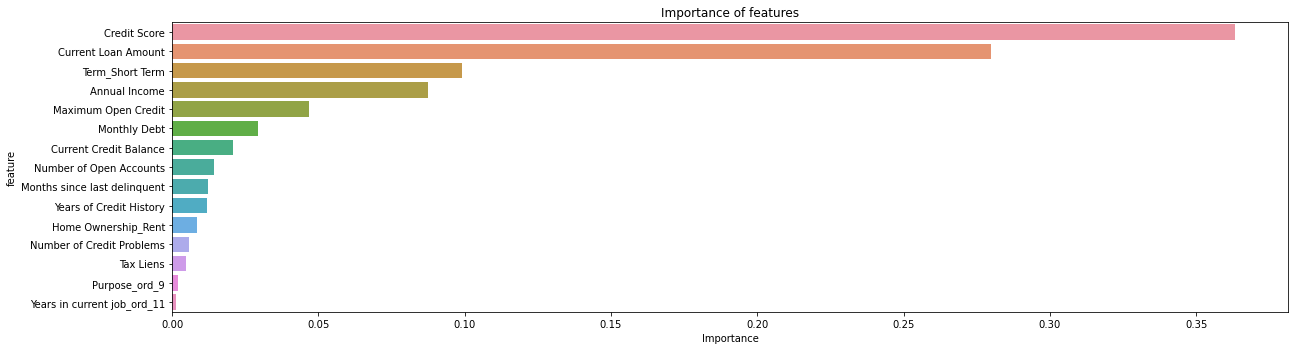

In [19]:
important_features_top = show_feature_importances(X_train.columns,
                                                  rfc.feature_importances_, get_top=15)

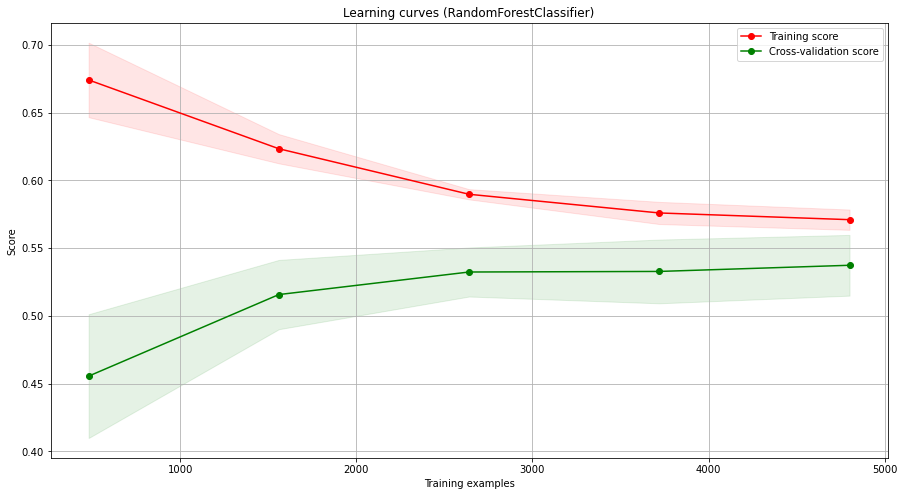

In [20]:
show_learning_curve_plot(rfc, X_train, y_train)

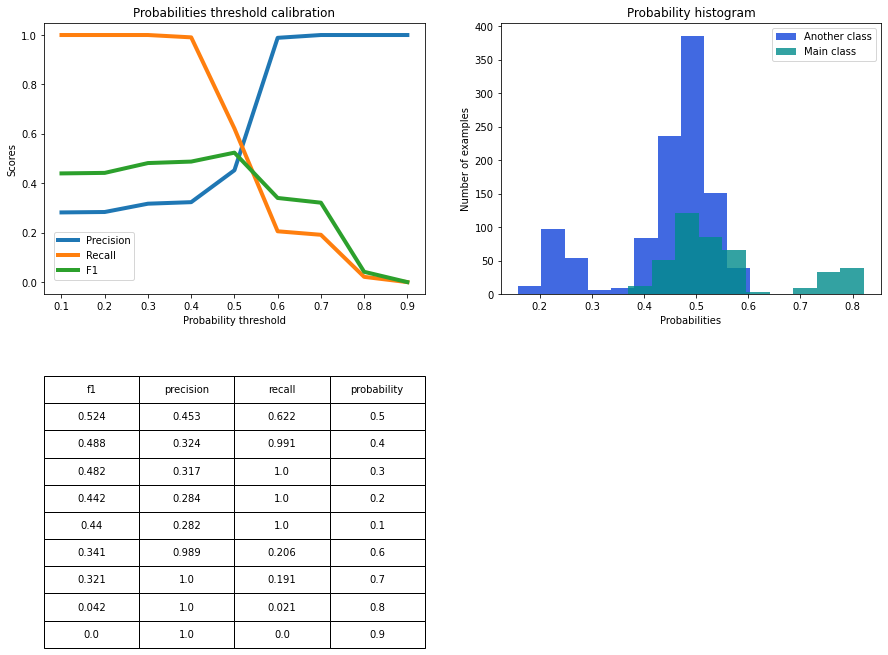

In [21]:
y_val_pred=rfc.predict_proba(X_val)
show_proba_calibration_plots(y_val_pred[:, 1], y_val)

Т.к. надо заполнять пропуски в "Annual Income" решила посмотреть как этот признак связан с остальными. Для начала построила матрицу корреляции:

**Матрица корреляции:**

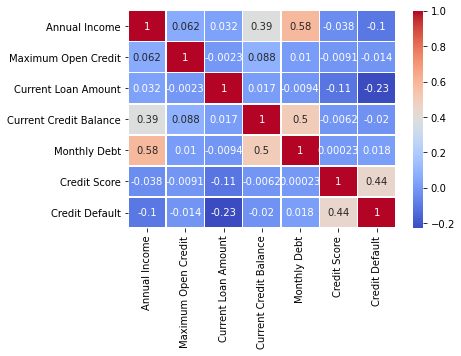

In [22]:
sns.heatmap(df_train[NUM_FEATURES+[TARGET_VAR]].corr(), annot=True, linewidths=.5, cmap='coolwarm')
plt.show()

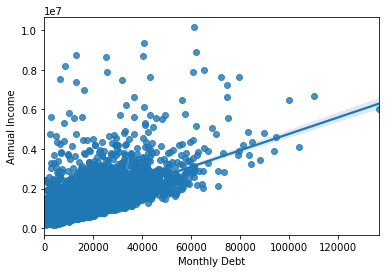

In [23]:
sns.regplot(x=df_train['Monthly Debt'], y=df_train['Annual Income'], dropna=True)
plt.show()

In [24]:
#Обработка пропусков

In [25]:
dfstat=df_train[["Annual Income","Monthly Debt"]].dropna(axis=0)
dfstat=df_test[["Annual Income","Monthly Debt"]].dropna(axis=0)

In [26]:
#Находим коэффициенты линейной регрессии
slope, intercept, r_value, p_value, std_err = stats.linregress(dfstat['Monthly Debt'], dfstat['Annual Income'])


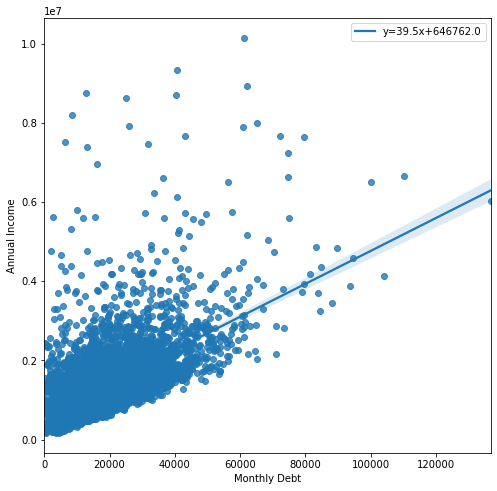

In [27]:
plt.figure(figsize=(8,8))
# use line_kws to set line label for legend
ax=sns.regplot(x=df_train['Monthly Debt'], y=df_train['Annual Income'], line_kws={'label':f"y={slope:.1f}x+{intercept:.1f}"})
ax.legend()

plt.show()

In [28]:
statmodel=df_train[NUM_FEATURES+[TARGET_VAR]]
columns=statmodel.columns.tolist()
for i in range(len(columns)):
    columns[i]='_'.join(columns[i].split()[j] for j in range(len(columns[i].split())))
statmodel.columns=columns

In [29]:
model = ols('Annual_Income~Monthly_Debt',data=statmodel).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Annual_Income   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     3088.
Date:                Wed, 05 Jan 2022   Prob (F-statistic):               0.00
Time:                        20:07:21   Log-Likelihood:                -88296.
No. Observations:                5943   AIC:                         1.766e+05
Df Residuals:                    5941   BIC:                         1.766e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6.061e+05   1.63e+04     37.143      0.000    5.74e+05    6.38e+05
Monthly_Debt    41.5927      0.748     55.570      0.000      40.125      43.060
==============================================================================
Omnibus:                     4685.087   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           148325.936
Skew:                           3.538   Prob(JB):                         0.00
Kurtosis:                      26.429   Cond. No.                     4.00e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

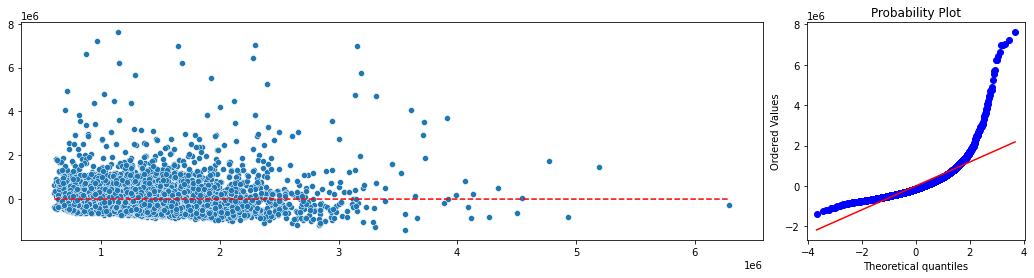

In [30]:
#проверяем условия применимости линейной регрессии
y_pred=model.predict(statmodel)
fig=plt.figure(figsize=(18,4))
gs = fig.add_gridspec(1, 4)
ax1 = fig.add_subplot(gs[0, :-1])
sns.scatterplot(x=y_pred, y=model.resid)
sns.lineplot(x=y_pred, y=0, color='r', linestyle='dashed')
ax2=fig.add_subplot(gs[0, -1])
stats.probplot(model.resid, dist="norm", plot=sns.mpl.pyplot) # y-y_pred=model.resid
plt.show()

На основании изучения остатков(отклонений) сделали вывод что:
Использовать результаты линейной регрессии для заполнения пропусков в графе 'Annual Income' мы не можем(т.к.не соблюдается распределения остатков и нормальности)
В итоге, в результате изучения признаков было решено не избавляться от пропусков

In [31]:
#обработка признаков, деление на трейн и валидацию, погонка модели

In [32]:
 class FeatureImputer3:
    
    def __init__(self):
        self.bancrupties=None
        
    def fit(self, X, y=None):
        self.bancrupties=0
        self.purpose_change='vacation'
        self.ho_change='Home Mortgage'
        self.cat_features=X.select_dtypes(include='object').columns.tolist()
        self.dcts=[{'Own Home':0,
                   'Rent':1,
                   'Home Mortgage':2                    
                   },
                   {'unknow':0,
                    '< 1 year':1,
                    '1 year':2,
                    '2 years':3,
                    '3 years':4,
                    '4 years':5,
                    '5 years':6,
                    '6 years':7,
                    '7 years':8,
                    '8 years':9,
                    '9 years':10,
                    '10+ years':11
                   },
                   {'business loan':0,
                    'buy a car':1,
                    'buy house':2,
                    'debt consolidation':3,
                    'educational expenses':4,
                    'home improvements':5,
                    'major purchase':6,
                    'medical bills':7,
                    'moving':8,
                    'other':9,
                    'small business':10,
                    'take a trip':11,
                    'vacation':12,
                    'wedding':13
                   },
                   {'Short Term':0,
                    'Long Term':1
                   }]
        return self
        
        
    def transform(self,X):
        X_trans=X.copy()
        X_trans['Bankruptcies'].fillna(self.bancrupties, inplace=True)
        X_trans['Annual Income'].fillna(X_trans['Monthly Debt']*41.5+606100, inplace=True)
        X_trans.loc[X_trans['Purpose']=='renewable energy', 'Purpose']=self.purpose_change
        X_trans.loc[X_trans['Home Ownership']=='Have Mortgage', 'Home Ownership']=self.ho_change
        X_trans['Years in current job'].fillna('unknow', inplace=True)
        new_cat_col=[]
        for num, column in enumerate(self.cat_features):
            X_trans.insert(X_trans.columns.get_loc(column)+1,column+'_ord',X_trans[column].map(self.dcts[num]))
            new_cat_col.append(column+'_ord')
            X_trans=X_trans.drop(column, axis=1)
        X_trans['Current Loan Amount_outline']=0
        X_trans.loc[X_trans['Current Loan Amount']>90000000, 'Current Loan Amount_outline']=1
        X_trans['Credit score_outline']=0
        X_trans.loc[X_trans['Credit Score']>5000, 'Credit score_outline']=1
        X_trans.loc[X_trans['Credit Score'].isna(), 'Credit Score']=0
        X_trans['Months since last delinquent_outline']=0
        X_trans.loc[df_train['Months since last delinquent'].isna(), 'Months since last delinquent_outline']=1
        X_trans['Months since last delinquent'].fillna(-1, inplace=True)
        X_trans=pd.get_dummies(X_trans, columns=new_cat_col, drop_first=True)
        return X_trans

### Разбиение обучающего датасета на train и test

In [33]:
train, val = train_test_split(df_train,
                               test_size=0.2,
                               shuffle=True,
                               stratify=df_train[TARGET_VAR],
                               random_state=12)

In [34]:
imputer3=FeatureImputer3()
train=imputer3.fit(train).transform(train)
val=imputer3.transform(val)

In [35]:
X_train, y_train, X_val, y_val = train.drop(TARGET_VAR, axis=1), train[TARGET_VAR], val.drop(TARGET_VAR, axis=1), val[TARGET_VAR]

In [36]:
#параметры модели

frozen_params1 = {'silent': True,
                 'random_state': 100,
                 'eval_metric': 'F1',
                 'class_weights': [1, 2.55],
                 'early_stopping_rounds': 100,
                 'depth': 5,
                 'iterations': 100,
                 'learning_rate': 0.1                 
                 }

### Обучение модели:

In [37]:
cat_model = CatBoostClassifier(**frozen_params1)
cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

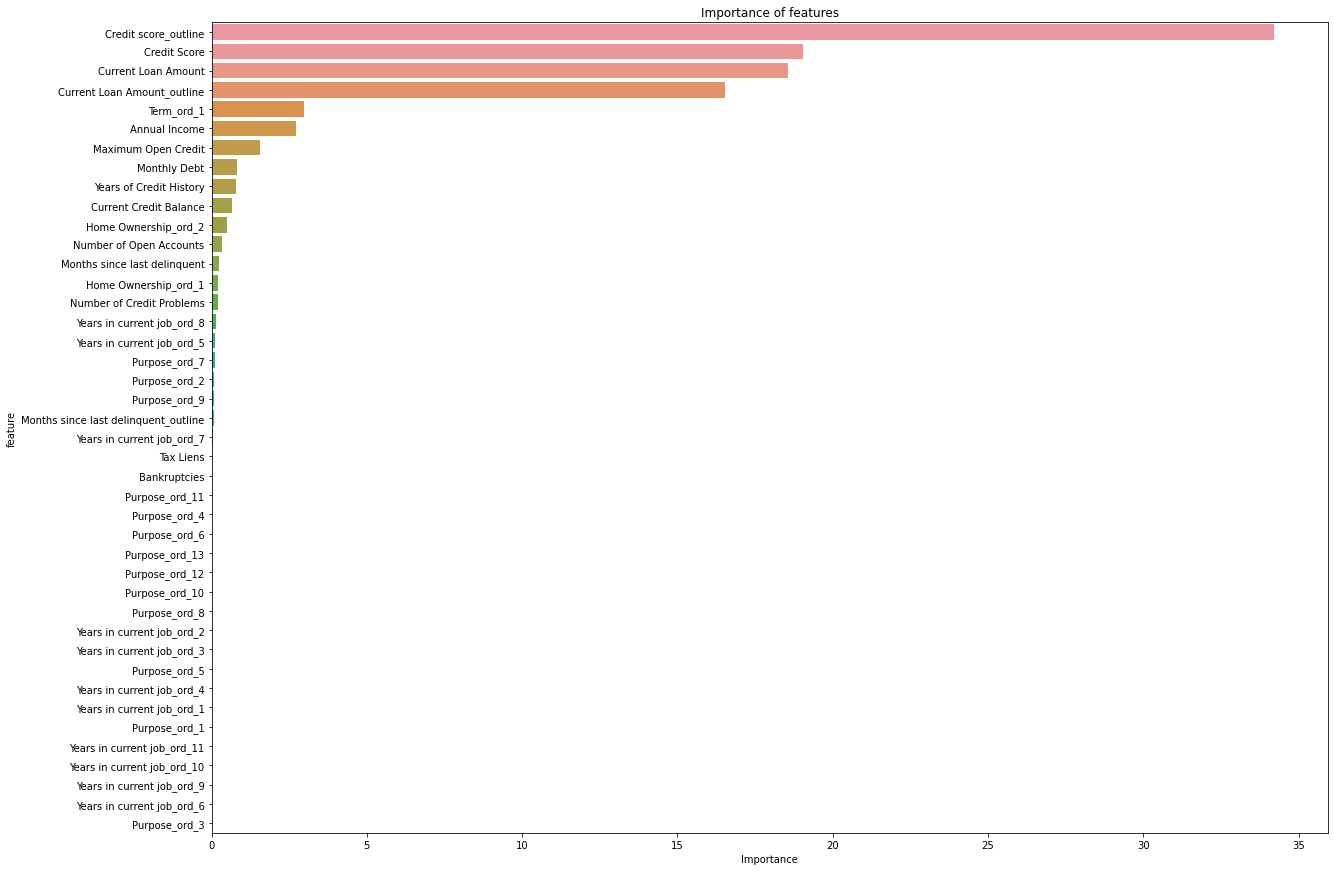

In [38]:
#Смотрим основные признаки для модели:
important_features_top = show_feature_importances(X_train.columns,
                                                  cat_model.feature_importances_)

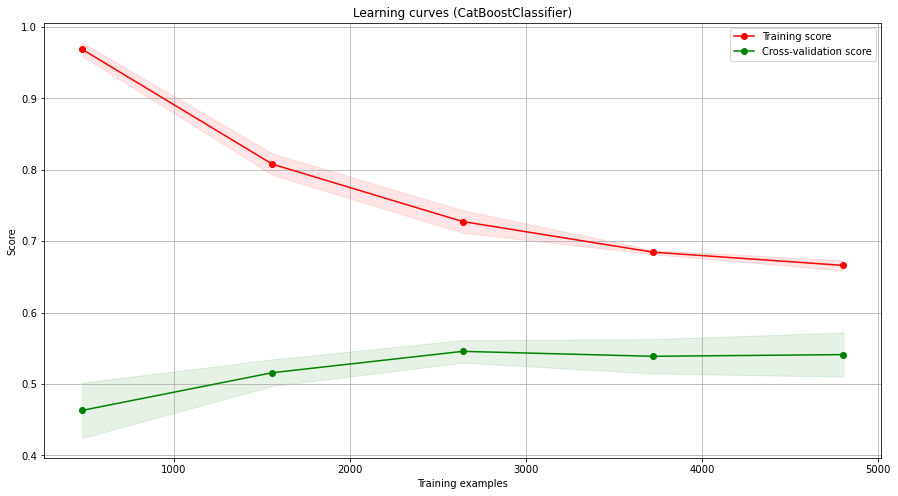

In [39]:
show_learning_curve_plot(cat_model, X_train, y_train)

In [40]:
y_val_pred=cat_model.predict_proba(X_val)

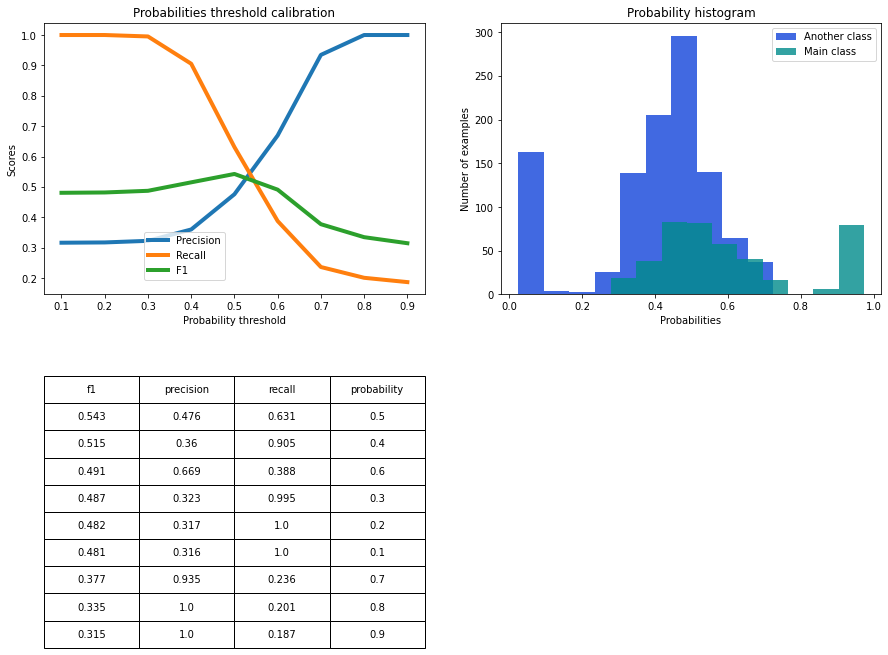

In [41]:
#смотрим на trashhold calibration
show_proba_calibration_plots(y_val_pred[:, 1], y_val)

In [42]:
#смотрим итоги
evaluate_preds(cat_model, X_train, X_val, y_train, y_val)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.75      0.80      4310
           1       0.51      0.67      0.58      1690

    accuracy                           0.73      6000
   macro avg       0.68      0.71      0.69      6000
weighted avg       0.76      0.73      0.74      6000

TEST

              precision    recall  f1-score   support

           0       0.83      0.73      0.78      1077
           1       0.48      0.63      0.54       423

    accuracy                           0.70      1500
   macro avg       0.65      0.68      0.66      1500
weighted avg       0.73      0.70      0.71      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               783  294
1               156  267


### Обучение финальной модели

Как оказалось, из этих вариантов можно собрать VotingClassifier.
Перед этим соберём пайплайн:

In [43]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [44]:
train, val = train_test_split(df_train,
                               test_size=0.2,
                               shuffle=True,
                               stratify=df_train[TARGET_VAR],
                               random_state=12)

In [45]:
X_train, y_train, X_val, y_val = train.drop(TARGET_VAR, axis=1), train[TARGET_VAR], val.drop(TARGET_VAR, axis=1), val[TARGET_VAR]

Для RandomForestClassifier применим первую модель, а для Catboost преобразуем признаки при помощи FeatureImputer3()
И объединим все в общий пайплайн

In [47]:
imp1=FeatureImputer1()
rfc=RandomForestClassifier(max_depth=5, class_weight={0:1,1:2.55}, random_state=100)
rf_pipe=Pipeline([('imputer', imp1), ('rfc',rfc)])
imp2=FeatureImputer3()
cbc=CatBoostClassifier(silent=True, class_weights={0:1,1:2.55}, learning_rate=0.005, random_seed=100, depth=5)
cbc_pipe=Pipeline([('imputer', imp2), ('cbc',cbc)])

In [48]:
vclf = VotingClassifier(estimators=[('p1', rf_pipe), ('p2', cbc_pipe)], voting='soft')
vclf.fit(X_train, y_train)
evaluate_preds(vclf, X_train, X_val, y_train, y_val)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.75      0.80      4310
           1       0.53      0.71      0.61      1690

    accuracy                           0.74      6000
   macro avg       0.70      0.73      0.71      6000
weighted avg       0.77      0.74      0.75      6000

TEST

              precision    recall  f1-score   support

           0       0.83      0.72      0.77      1077
           1       0.47      0.64      0.54       423

    accuracy                           0.69      1500
   macro avg       0.65      0.68      0.65      1500
weighted avg       0.73      0.69      0.71      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               771  306
1               154  269


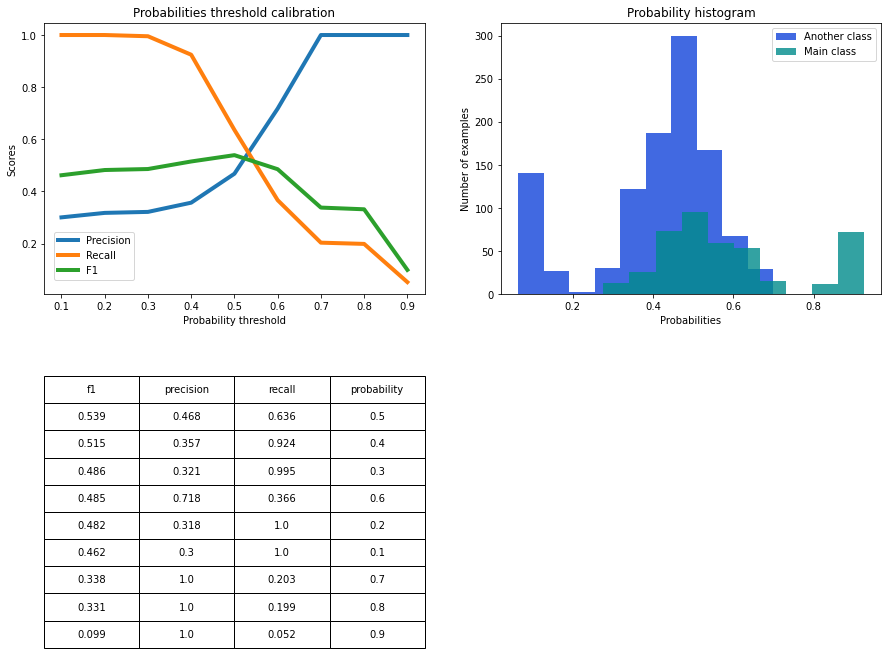

In [49]:
y_val_pred=vclf.predict_proba(X_val)
show_proba_calibration_plots(y_val_pred[:, 1], y_val)

In [50]:
y_pred=vclf.predict(df_test)
result=pd.DataFrame({'Id':np.arange(2500), 'Credit Default': y_pred})

In [51]:
RESULT_PATH_2= './RNiyazova_credit_default.csv'
result.to_csv(RESULT_PATH_2, index=False, encoding='utf-8', sep=',')

In [52]:
#RESULT_PATH= './RNiyazova_credit_default.txt'
with open('RNiyazova_credit_default', 'wb') as file:
    pickle.dump(vclf, file)

In [ ]:
# ник на Kaggle Anna.NR